# Lucas-Kanade: Tracking en Video de Ejemplo

**Objetivo:** Aplicar Lucas-Kanade a un video con múltiples frames, implementando tracking temporal de puntos.

## Nuevos Conceptos en este Notebook

1. **Detección de buenos puntos**: Usar Shi-Tomasi para encontrar esquinas (puntos con textura)
2. **Tracking temporal**: Propagar puntos frame a frame
3. **Gestión de puntos perdidos**: Detectar cuando se pierde el tracking
4. **Visualización de trayectorias**: Ver el camino recorrido por cada punto
5. **Preparación para video real**: Código modular y reutilizable

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import cv2

plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

---
## Paso 1: Generar Video Sintético con Movimiento Complejo

Crearemos una secuencia de 30 frames con:
- Un **círculo** que se mueve en trayectoria circular
- Un **cuadrado** que se mueve horizontalmente
- Un **triángulo** que rota sobre sí mismo

**Pregunta:** ¿Por qué estos patrones de movimiento son buenos para probar Lucas-Kanade?

Video generado: 30 frames de (200, 300)


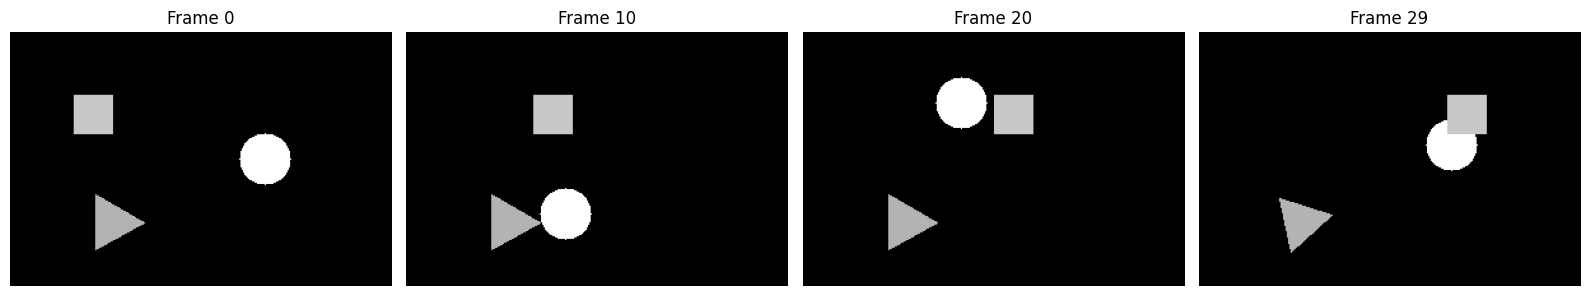

In [2]:
def generar_video_sintetico(num_frames=30, altura=200, ancho=300):
    """
    Genera un video sintético con múltiples objetos en movimiento.
    
    Returns:
        frames: Lista de frames (numpy arrays)
    """
    frames = []
    
    for t in range(num_frames):
        # Frame negro
        frame = np.zeros((altura, ancho), dtype=np.uint8)
        
        # 1. Círculo en movimiento circular
        centro_x = int(150 + 50 * np.cos(2 * np.pi * t / num_frames))
        centro_y = int(100 + 50 * np.sin(2 * np.pi * t / num_frames))
        cv2.circle(frame, (centro_x, centro_y), 20, 255, -1)
        
        # 2. Cuadrado moviéndose horizontalmente
        cuadrado_x = int(50 + 150 * t / num_frames)
        cuadrado_y = 50
        cv2.rectangle(frame, 
                     (cuadrado_x, cuadrado_y),
                     (cuadrado_x + 30, cuadrado_y + 30),
                     200, -1)
        
        # 3. Triángulo rotando (aproximado con polígono)
        angulo = 2 * np.pi * t / num_frames
        centro_tri = np.array([80, 150])
        radio = 25
        
        # Vértices del triángulo
        vertices = []
        for i in range(3):
            theta = angulo + i * 2 * np.pi / 3
            x = int(centro_tri[0] + radio * np.cos(theta))
            y = int(centro_tri[1] + radio * np.sin(theta))
            vertices.append([x, y])
        
        vertices = np.array(vertices, dtype=np.int32)
        cv2.fillPoly(frame, [vertices], 180)
        
        frames.append(frame)
    
    return frames

# Generar video
frames = generar_video_sintetico(num_frames=30)

print(f"Video generado: {len(frames)} frames de {frames[0].shape}")

# Visualizar algunos frames
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
frames_a_mostrar = [0, 10, 20, 29]

for idx, frame_num in enumerate(frames_a_mostrar):
    axes[idx].imshow(frames[frame_num], cmap='gray')
    axes[idx].set_title(f'Frame {frame_num}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

---
## Paso 2: Detectar Buenos Puntos para Tracking

No todos los píxeles son buenos para hacer tracking. Necesitamos puntos con **textura fuerte** (esquinas, bordes).

### Detector de Esquinas Shi-Tomasi

El criterio de Shi-Tomasi evalúa la **matriz de estructura local**:

$$M = \begin{bmatrix}
\sum I_x^2 & \sum I_x I_y \\
\sum I_x I_y & \sum I_y^2
\end{bmatrix}$$

Un punto es bueno si ambos eigenvalores de $M$ son grandes (indica gradientes fuertes en múltiples direcciones).

**Pregunta:** ¿Reconoces esta matriz $M$? Es exactamente $A^T A$ de Lucas-Kanade. ¿Por qué tiene sentido usar esto para seleccionar puntos?

Puntos detectados: 19


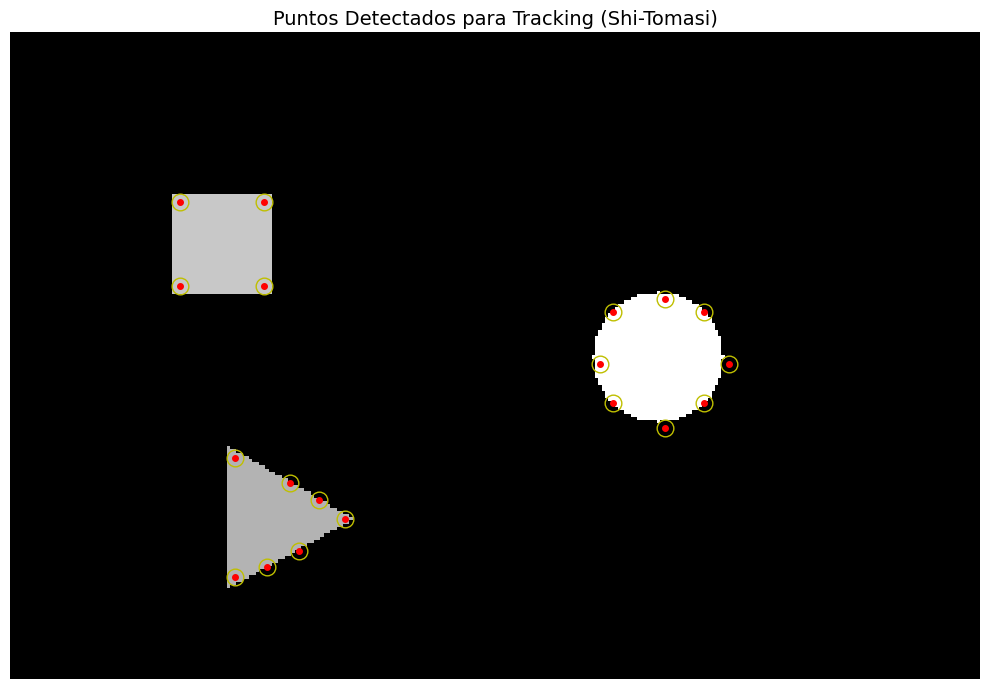


¿Qué observas?
- Los puntos están en los BORDES de los objetos (donde hay gradientes fuertes)
- NO hay puntos en regiones uniformes (centro de los objetos)
- Esto es exactamente lo que queremos para Lucas-Kanade


In [3]:
def detectar_puntos_para_tracking(frame, max_puntos=100, calidad=0.01, distancia_min=10):
    """
    Detecta buenos puntos (esquinas) para tracking usando Shi-Tomasi.
    
    Args:
        frame: Frame en escala de grises
        max_puntos: Número máximo de puntos a detectar
        calidad: Nivel mínimo de calidad (0-1). Puntos con eigenvalor < calidad*max_eigenvalor son rechazados
        distancia_min: Distancia mínima entre puntos
    
    Returns:
        puntos: Array de shape (N, 1, 2) con coordenadas [x, y]
    """
    puntos = cv2.goodFeaturesToTrack(
        frame,
        maxCorners=max_puntos,
        qualityLevel=calidad,
        minDistance=distancia_min,
        blockSize=7
    )
    
    return puntos

# Detectar puntos en el primer frame
frame_inicial = frames[0]
puntos_iniciales = detectar_puntos_para_tracking(frame_inicial, max_puntos=50)

print(f"Puntos detectados: {len(puntos_iniciales)}")

# Visualizar puntos detectados
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(frame_inicial, cmap='gray')

# Dibujar puntos
for punto in puntos_iniciales:
    x, y = punto[0]
    ax.plot(x, y, 'r.', markersize=8)
    ax.plot(x, y, 'yo', markersize=12, fillstyle='none')

ax.set_title('Puntos Detectados para Tracking (Shi-Tomasi)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

print("\n¿Qué observas?")
print("- Los puntos están en los BORDES de los objetos (donde hay gradientes fuertes)")
print("- NO hay puntos en regiones uniformes (centro de los objetos)")
print("- Esto es exactamente lo que queremos para Lucas-Kanade")

---
## Paso 3: Tracking Frame a Frame con Lucas-Kanade

Ahora vamos a **propagar** los puntos detectados a través de todos los frames.

### Algoritmo:

```
1. Detectar puntos en frame 0
2. Para cada frame i = 1, 2, ..., N:
   a. Calcular flujo de frame i-1 a frame i
   b. Actualizar posición de cada punto
   c. Verificar si el tracking es válido
   d. Descartar puntos perdidos
```

**Pregunta:** ¿Qué crees que significa que un punto esté "perdido" o el tracking no sea "válido"?

In [4]:
def tracking_lucas_kanade(frames, puntos_iniciales, tamaño_ventana=15, max_nivel_piramide=2):
    """
    Realiza tracking de puntos a través de múltiples frames usando Lucas-Kanade.
    
    Args:
        frames: Lista de frames
        puntos_iniciales: Puntos detectados en el primer frame
        tamaño_ventana: Tamaño de ventana para Lucas-Kanade
        max_nivel_piramide: Niveles de pirámide (para manejar movimientos grandes)
    
    Returns:
        trayectorias: Dict con id_punto -> lista de coordenadas [(x,y), ...]
        puntos_por_frame: Lista de puntos válidos en cada frame
    """
    # Parámetros de Lucas-Kanade
    lk_params = dict(
        winSize=(tamaño_ventana, tamaño_ventana),
        maxLevel=max_nivel_piramide,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )
    
    # Inicializar estructuras de datos
    trayectorias = {i: [(puntos_iniciales[i][0][0], puntos_iniciales[i][0][1])] 
                   for i in range(len(puntos_iniciales))}
    
    puntos_actuales = puntos_iniciales.copy()
    puntos_por_frame = [puntos_iniciales.copy()]
    ids_activos = list(range(len(puntos_iniciales)))
    
    # Tracking frame a frame
    for i in range(1, len(frames)):
        frame_anterior = frames[i-1]
        frame_actual = frames[i]
        
        # Calcular flujo óptico
        puntos_nuevos, status, error = cv2.calcOpticalFlowPyrLK(
            frame_anterior, frame_actual, 
            puntos_actuales, None, 
            **lk_params
        )
        
        # Filtrar puntos válidos
        buenos_nuevos = []
        ids_nuevos = []
        
        for j, (nuevo, st, id_punto) in enumerate(zip(puntos_nuevos, status, ids_activos)):
            if st[0] == 1:  # Tracking exitoso
                x_nuevo, y_nuevo = nuevo[0]
                
                # Verificar que el punto esté dentro del frame
                if 0 <= x_nuevo < frames[0].shape[1] and 0 <= y_nuevo < frames[0].shape[0]:
                    buenos_nuevos.append(nuevo)
                    ids_nuevos.append(id_punto)
                    trayectorias[id_punto].append((x_nuevo, y_nuevo))
        
        if len(buenos_nuevos) > 0:
            puntos_actuales = np.array(buenos_nuevos).reshape(-1, 1, 2)
            ids_activos = ids_nuevos
            puntos_por_frame.append(puntos_actuales.copy())
        else:
            puntos_actuales = np.array([]).reshape(-1, 1, 2)
            ids_activos = []
            puntos_por_frame.append(puntos_actuales)
        
        print(f"Frame {i}: {len(puntos_actuales)} puntos activos")
    
    return trayectorias, puntos_por_frame

# Ejecutar tracking
print("Iniciando tracking...\n")
trayectorias, puntos_por_frame = tracking_lucas_kanade(
    frames, 
    puntos_iniciales,
    tamaño_ventana=21,
    max_nivel_piramide=3
)

print(f"\nTracking completado.")
print(f"Puntos iniciales: {len(puntos_iniciales)}")
print(f"Puntos al final: {len(puntos_por_frame[-1])}")
print(f"Trayectorias completas (presentes en todos los frames): {sum(1 for t in trayectorias.values() if len(t) == len(frames))}")

Iniciando tracking...

Frame 1: 19 puntos activos
Frame 2: 19 puntos activos
Frame 3: 19 puntos activos
Frame 4: 19 puntos activos
Frame 5: 19 puntos activos
Frame 6: 19 puntos activos
Frame 7: 19 puntos activos
Frame 8: 19 puntos activos
Frame 9: 19 puntos activos
Frame 10: 19 puntos activos
Frame 11: 19 puntos activos
Frame 12: 19 puntos activos
Frame 13: 19 puntos activos
Frame 14: 19 puntos activos
Frame 15: 19 puntos activos
Frame 16: 18 puntos activos
Frame 17: 18 puntos activos
Frame 18: 18 puntos activos
Frame 19: 18 puntos activos
Frame 20: 18 puntos activos
Frame 21: 17 puntos activos
Frame 22: 17 puntos activos
Frame 23: 17 puntos activos
Frame 24: 17 puntos activos
Frame 25: 17 puntos activos
Frame 26: 16 puntos activos
Frame 27: 16 puntos activos
Frame 28: 14 puntos activos
Frame 29: 14 puntos activos

Tracking completado.
Puntos iniciales: 19
Puntos al final: 14
Trayectorias completas (presentes en todos los frames): 14


---
## Paso 4: Visualizar Trayectorias

Las trayectorias muestran el camino completo que siguió cada punto a lo largo del video.

**Pregunta de reflexión:** ¿Qué forma deberían tener las trayectorias de los puntos en:
1. El círculo (movimiento circular)
2. El cuadrado (movimiento horizontal)
3. El triángulo (rotación)?

Trayectorias en diferentes momentos del video:



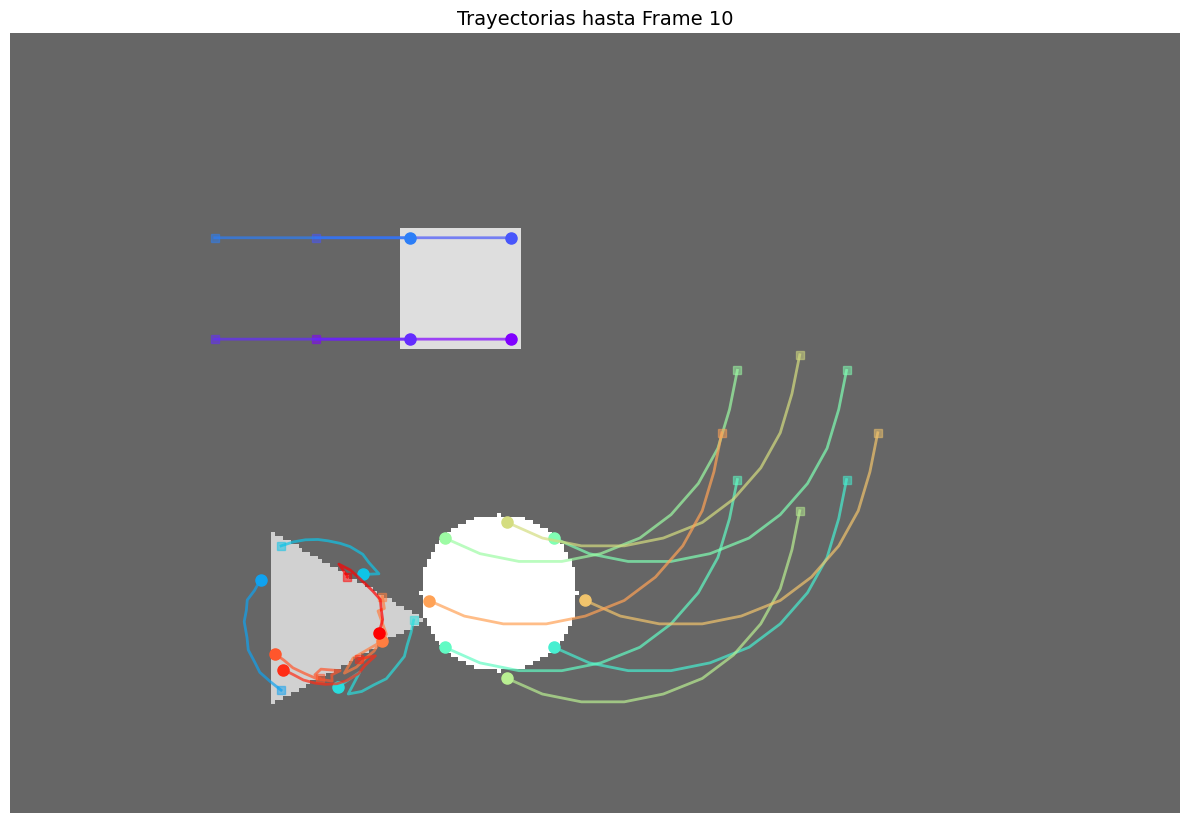

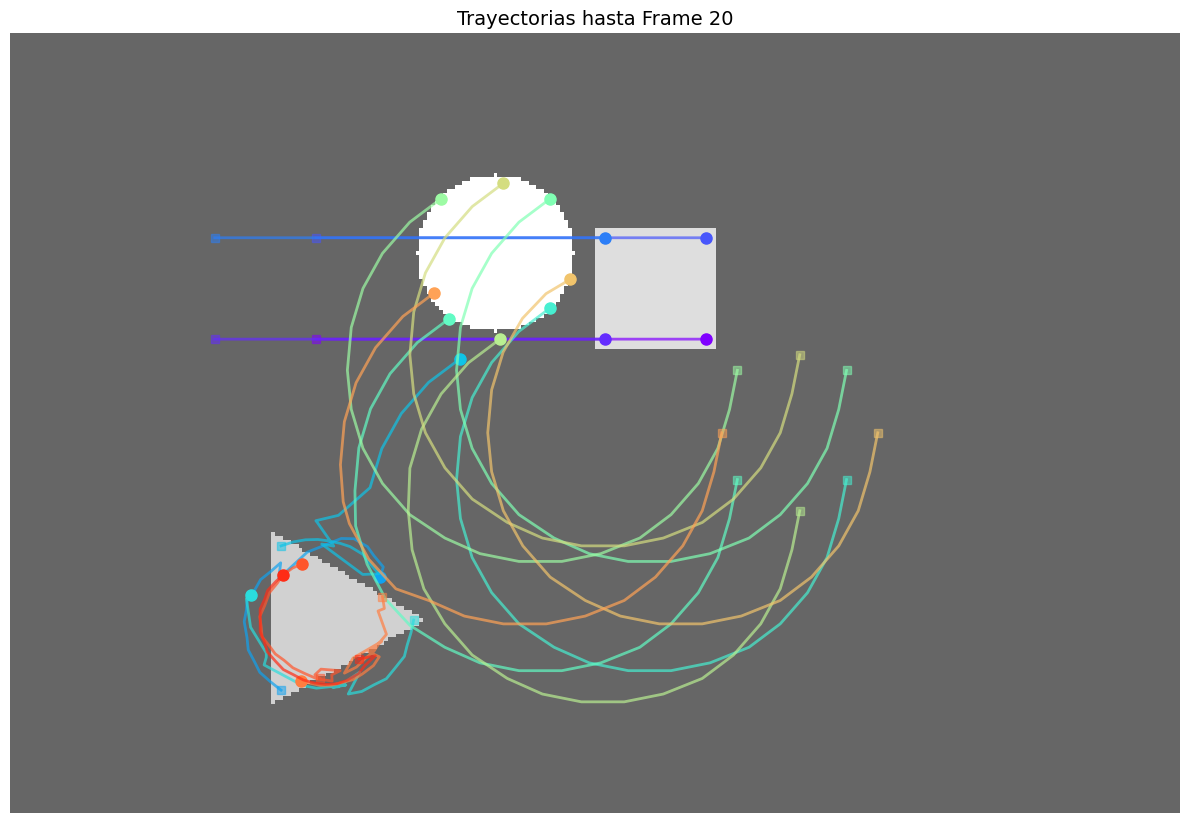

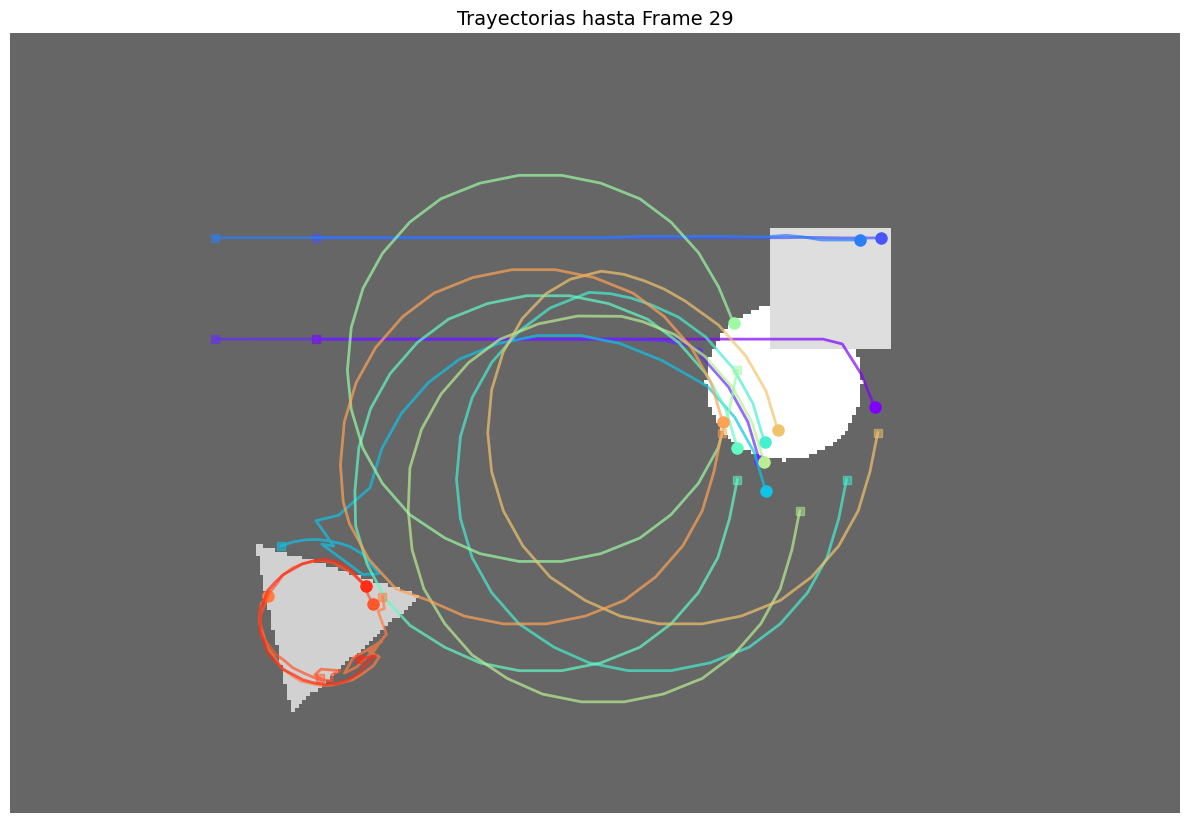

In [5]:
def visualizar_trayectorias(frames, trayectorias, frame_num=-1):
    """
    Visualiza las trayectorias de los puntos hasta un frame específico.
    
    Args:
        frames: Lista de frames
        trayectorias: Dict de trayectorias
        frame_num: Frame a visualizar (-1 para el último)
    """
    if frame_num < 0:
        frame_num = len(frames) - 1
    
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.imshow(frames[frame_num], cmap='gray', alpha=0.6)
    
    # Dibujar trayectorias
    colores = plt.cm.rainbow(np.linspace(0, 1, len(trayectorias)))
    
    for idx, (id_punto, trayectoria) in enumerate(trayectorias.items()):
        if len(trayectoria) > frame_num:
            # Trayectoria hasta el frame actual
            trayectoria_parcial = trayectoria[:frame_num+1]
            xs = [p[0] for p in trayectoria_parcial]
            ys = [p[1] for p in trayectoria_parcial]
            
            # Dibujar línea de trayectoria
            ax.plot(xs, ys, '-', color=colores[idx], linewidth=2, alpha=0.7)
            
            # Marcar posición actual
            ax.plot(xs[-1], ys[-1], 'o', color=colores[idx], markersize=8)
            
            # Marcar posición inicial
            ax.plot(xs[0], ys[0], 's', color=colores[idx], markersize=6, alpha=0.5)
    
    ax.set_title(f'Trayectorias hasta Frame {frame_num}', fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar en diferentes momentos
print("Trayectorias en diferentes momentos del video:\n")
for frame_idx in [10, 20, 29]:
    visualizar_trayectorias(frames, trayectorias, frame_idx)

---
## Paso 5: Análisis de Calidad del Tracking

No todos los puntos se trackean perfectamente. Analicemos:
1. ¿Cuántos puntos sobreviven hasta el final?
2. ¿Dónde se pierden los puntos?
3. ¿Qué caracteriza a las trayectorias "buenas"?

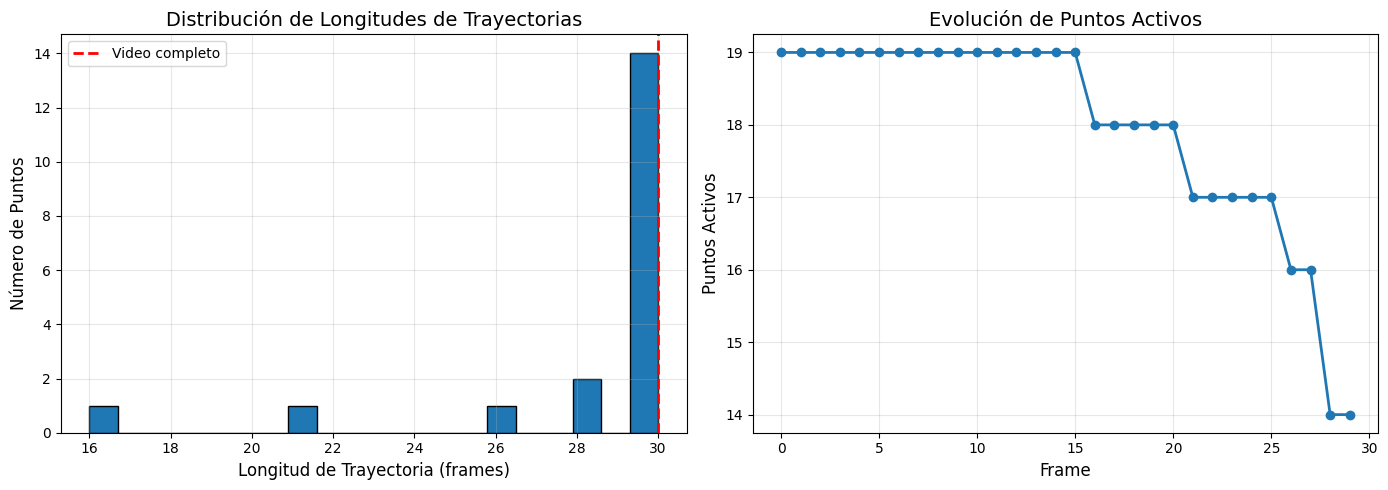


=== ESTADÍSTICAS DE TRACKING ===

Puntos iniciales: 19
Puntos que completaron todo el video: 14
Tasa de supervivencia: 73.7%

Longitud promedio de trayectoria: 28.4 frames
Longitud mínima: 16 frames
Longitud máxima: 30 frames


In [6]:
# Análisis de supervivencia de puntos
longitudes_trayectorias = [len(t) for t in trayectorias.values()]
num_frames_total = len(frames)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de longitudes de trayectorias
axes[0].hist(longitudes_trayectorias, bins=20, edgecolor='black')
axes[0].axvline(num_frames_total, color='red', linestyle='--', linewidth=2, label='Video completo')
axes[0].set_xlabel('Longitud de Trayectoria (frames)', fontsize=12)
axes[0].set_ylabel('Número de Puntos', fontsize=12)
axes[0].set_title('Distribución de Longitudes de Trayectorias', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Puntos activos por frame
puntos_activos_por_frame = [len(pts) for pts in puntos_por_frame]
axes[1].plot(range(len(puntos_activos_por_frame)), puntos_activos_por_frame, 'o-', linewidth=2)
axes[1].set_xlabel('Frame', fontsize=12)
axes[1].set_ylabel('Puntos Activos', fontsize=12)
axes[1].set_title('Evolución de Puntos Activos', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas
print("\n=== ESTADÍSTICAS DE TRACKING ===")
print(f"\nPuntos iniciales: {len(puntos_iniciales)}")
print(f"Puntos que completaron todo el video: {sum(1 for l in longitudes_trayectorias if l == num_frames_total)}")
print(f"Tasa de supervivencia: {100 * sum(1 for l in longitudes_trayectorias if l == num_frames_total) / len(puntos_iniciales):.1f}%")
print(f"\nLongitud promedio de trayectoria: {np.mean(longitudes_trayectorias):.1f} frames")
print(f"Longitud mínima: {min(longitudes_trayectorias)} frames")
print(f"Longitud máxima: {max(longitudes_trayectorias)} frames")

---
## Paso 6: Comparación con Implementación Manual

Vamos a comparar dos frames específicos usando nuestra implementación manual del notebook anterior.

In [7]:
# Funciones del notebook anterior (implementación manual)
def calcular_gradiente_sobel(img):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)
    Ix = cv2.filter2D(img.astype(np.float32), -1, sobel_x)
    Iy = cv2.filter2D(img.astype(np.float32), -1, sobel_y)
    return Ix, Iy

def lucas_kanade_ventana(Ix, Iy, It, x, y, tamaño_ventana=5):
    medio = tamaño_ventana // 2
    y_min, y_max = y - medio, y + medio + 1
    x_min, x_max = x - medio, x + medio + 1
    
    if y_min < 0 or y_max > Ix.shape[0] or x_min < 0 or x_max > Ix.shape[1]:
        return 0.0, 0.0
    
    Ix_ventana = Ix[y_min:y_max, x_min:x_max].flatten()
    Iy_ventana = Iy[y_min:y_max, x_min:x_max].flatten()
    It_ventana = It[y_min:y_max, x_min:x_max].flatten()
    
    A = np.vstack([Ix_ventana, Iy_ventana]).T
    b = -It_ventana.reshape(-1, 1)
    
    ATA = A.T @ A
    ATb = A.T @ b
    
    det = np.linalg.det(ATA)
    if abs(det) < 1e-7:
        return 0.0, 0.0
    
    ATA_inv = np.linalg.inv(ATA)
    v = ATA_inv @ ATb
    
    return v[0, 0], v[1, 0]

# Comparar frames 0 y 1
frame1 = frames[0].astype(np.float32)
frame2 = frames[1].astype(np.float32)

img_prom = (frame1 + frame2) / 2.0
Ix, Iy = calcular_gradiente_sobel(img_prom)
It = frame2 - frame1

# Calcular flujo manualmente en algunos puntos
puntos_test = puntos_iniciales[:10]  # Primeros 10 puntos

print("Comparación: Implementación Manual vs OpenCV\n")
print(f"{'Punto':<8} {'Manual (u,v)':<20} {'OpenCV (u,v)':<20} {'Diferencia':<15}")
print("-" * 70)

for i, punto in enumerate(puntos_test):
    x, y = int(punto[0][0]), int(punto[0][1])
    
    # Manual
    u_manual, v_manual = lucas_kanade_ventana(Ix, Iy, It, x, y, tamaño_ventana=21)
    
    # OpenCV (ya calculado)
    tray = trayectorias[i]
    if len(tray) >= 2:
        u_opencv = tray[1][0] - tray[0][0]
        v_opencv = tray[1][1] - tray[0][1]
    else:
        u_opencv, v_opencv = 0, 0
    
    diff = np.sqrt((u_manual - u_opencv)**2 + (v_manual - v_opencv)**2)
    
    print(f"{i:<8} ({u_manual:6.2f}, {v_manual:6.2f})  ({u_opencv:6.2f}, {v_opencv:6.2f})  {diff:6.3f}")

print("\n✓ Ambas implementaciones dan resultados muy similares")

Comparación: Implementación Manual vs OpenCV

Punto    Manual (u,v)         OpenCV (u,v)         Diferencia     
----------------------------------------------------------------------
0        (  0.25,   0.01)  (  5.00,  -0.00)   4.748
1        (  0.25,  -0.02)  (  5.00,   0.00)   4.749
2        (  0.25,  -0.01)  (  5.00,  -0.00)   4.748
3        (  0.25,   0.02)  (  5.00,  -0.00)   4.750
4        ( -0.20,  -0.16)  ( -2.60,  -2.05)   3.054
5        (  0.23,  -0.12)  (  3.23,  -1.03)   3.130
6        ( -0.05,   0.25)  ( -0.68,   3.26)   3.065
7        ( -0.01,   0.34)  ( -2.00,  10.00)   9.860
8        ( -0.25,   0.18)  ( -2.00,  10.00)   9.974
9        ( -0.22,   0.21)  ( -2.00,  10.00)   9.952

✓ Ambas implementaciones dan resultados muy similares


---
## Paso 7: Función Reutilizable para Video Real

Ahora creamos una función "lista para usar" que puedas aplicar directamente a tu video capturado.

Video cargado: 314 frames de (720, 1280)

Detectando puntos en el primer frame...
Puntos detectados: 50

Iniciando tracking con Lucas-Kanade...
Frame 1: 50 puntos activos
Frame 2: 50 puntos activos
Frame 3: 50 puntos activos
Frame 4: 50 puntos activos
Frame 5: 50 puntos activos
Frame 6: 50 puntos activos
Frame 7: 50 puntos activos
Frame 8: 50 puntos activos
Frame 9: 50 puntos activos
Frame 10: 50 puntos activos
Frame 11: 50 puntos activos
Frame 12: 50 puntos activos
Frame 13: 50 puntos activos
Frame 14: 50 puntos activos
Frame 15: 50 puntos activos
Frame 16: 50 puntos activos
Frame 17: 50 puntos activos
Frame 18: 50 puntos activos
Frame 19: 50 puntos activos
Frame 20: 49 puntos activos
Frame 21: 49 puntos activos
Frame 22: 49 puntos activos
Frame 23: 49 puntos activos
Frame 24: 49 puntos activos
Frame 25: 49 puntos activos
Frame 26: 49 puntos activos
Frame 27: 49 puntos activos
Frame 28: 49 puntos activos
Frame 29: 49 puntos activos
Frame 30: 49 puntos activos
Frame 31: 49 puntos activ

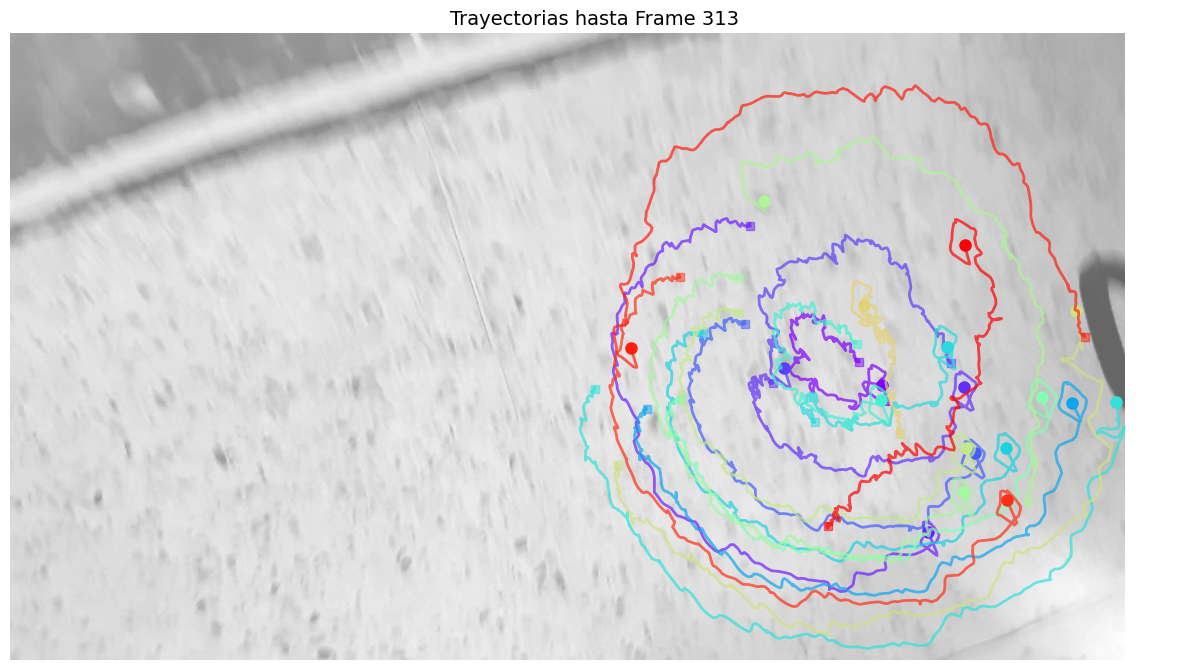

In [10]:
def procesar_video_optical_flow(video_path=None, frames=None, 
                                max_puntos=100, 
                                tamaño_ventana=21,
                                max_nivel_piramide=3,
                                visualizar=True):
    """
    Pipeline completo para procesar un video y extraer flujo óptico.
    
    Args:
        video_path: Ruta al archivo de video (si None, usar frames directamente)
        frames: Lista de frames (si video_path es None)
        max_puntos: Número máximo de puntos a trackear
        tamaño_ventana: Tamaño de ventana para Lucas-Kanade
        max_nivel_piramide: Niveles de pirámide
        visualizar: Si True, genera visualizaciones
    
    Returns:
        trayectorias: Dict con las trayectorias de cada punto
        frames_procesados: Lista de frames
        puntos_por_frame: Lista de puntos en cada frame
    """
    # Cargar video si se proporciona path
    if video_path is not None:
        cap = cv2.VideoCapture(video_path)
        frames = []
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convertir a escala de grises
            if len(frame.shape) == 3:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            frames.append(frame)
        
        cap.release()
        print(f"Video cargado: {len(frames)} frames de {frames[0].shape}")
    
    # Paso 1: Detectar puntos
    print(f"\nDetectando puntos en el primer frame...")
    puntos_iniciales = detectar_puntos_para_tracking(
        frames[0], 
        max_puntos=max_puntos,
        calidad=0.01,
        distancia_min=10
    )
    print(f"Puntos detectados: {len(puntos_iniciales)}")
    
    # Paso 2: Tracking
    print(f"\nIniciando tracking con Lucas-Kanade...")
    trayectorias, puntos_por_frame = tracking_lucas_kanade(
        frames, 
        puntos_iniciales,
        tamaño_ventana=tamaño_ventana,
        max_nivel_piramide=max_nivel_piramide
    )
    
    # Paso 3: Visualizar si se solicita
    if visualizar:
        print("\nGenerando visualizaciones...")
        visualizar_trayectorias(frames, trayectorias, -1)
    
    return trayectorias, frames, puntos_por_frame

trayectorias, frames, puntos_por_frame = procesar_video_optical_flow(
    video_path='20251008_120434.mp4',
    max_puntos=50,           # Ajustar según necesidad
    tamaño_ventana=21,       # Más grande si hay ruido
    max_nivel_piramide=3,    # Más niveles si hay movimiento rápido
    visualizar=True
)

---
## Paso 8: Visualización Interactiva (Opcional)

Crear una visualización frame por frame mostrando el tracking en tiempo real.

In [11]:
def crear_video_con_tracking(frames, puntos_por_frame, trayectorias, output_path='tracking_output.mp4', fps=10):
    """
    Crea un video mostrando los puntos trackeados con flechas de flujo óptico.
    
    Args:
        frames: Lista de frames
        puntos_por_frame: Lista de puntos en cada frame
        trayectorias: Dict con las trayectorias de cada punto
        output_path: Ruta donde guardar el video
        fps: Frames por segundo
    """
    altura, ancho = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (ancho, altura))
    
    # Mapeo de puntos a sus IDs de trayectoria
    # Necesitamos rastrear qué punto corresponde a qué trayectoria
    ids_activos = list(trayectorias.keys())
    
    for i, (frame, puntos) in enumerate(zip(frames, puntos_por_frame)):
        # Convertir a color para dibujar
        frame_color = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        
        # Actualizar IDs activos basados en el número de puntos
        # (algunos puntos pueden perderse entre frames)
        if len(puntos) < len(ids_activos):
            # Filtrar IDs que todavía tienen trayectorias válidas en este frame
            nuevos_ids = []
            for id_traj in ids_activos:
                if len(trayectorias[id_traj]) > i:
                    nuevos_ids.append(id_traj)
            ids_activos = nuevos_ids[:len(puntos)]
        
        # Dibujar flechas de flujo óptico
        for j, punto in enumerate(puntos):
            x_actual, y_actual = int(punto[0][0]), int(punto[0][1])
            
            # Obtener la posición anterior si existe
            if i > 0 and j < len(ids_activos):
                id_traj = ids_activos[j]
                if id_traj in trayectorias and len(trayectorias[id_traj]) > i:
                    # Posición anterior
                    x_anterior, y_anterior = trayectorias[id_traj][i-1]
                    x_anterior, y_anterior = int(x_anterior), int(y_anterior)
                    
                    # Calcular el vector de movimiento
                    dx = x_actual - x_anterior
                    dy = y_actual - y_anterior
                    
                    # Calcular la magnitud del movimiento
                    magnitud = np.sqrt(dx**2 + dy**2)
                    
                    # Solo dibujar flecha si hay movimiento significativo
                    if magnitud > 0.5:
                        # Escalar la flecha para que sea visible (multiplicar por factor)
                        factor_escala = 3
                        x_fin = int(x_actual + dx * factor_escala)
                        y_fin = int(y_actual + dy * factor_escala)
                        
                        # Dibujar flecha (azul para el flujo óptico)
                        cv2.arrowedLine(frame_color, 
                                       (x_actual, y_actual), 
                                       (x_fin, y_fin), 
                                       (255, 0, 0),  # Azul
                                       2, 
                                       tipLength=0.3)
            
            # Dibujar punto actual (verde)
            cv2.circle(frame_color, (x_actual, y_actual), 3, (0, 255, 0), -1)
        
        # Añadir texto con información
        cv2.putText(frame_color, f'Frame: {i}', (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame_color, f'Puntos: {len(puntos)}', (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        out.write(frame_color)
    
    out.release()
    print(f"Video guardado en: {output_path}")

# Crear video con tracking y flechas de flujo óptico
crear_video_con_tracking(frames, puntos_por_frame, trayectorias, 'tracking_ejemplo.mp4', fps=5)

print("\n✓ Video con tracking y flechas de flujo óptico generado.")
print("  Las flechas azules muestran la dirección y magnitud del movimiento.")
print("  Los puntos verdes indican la posición actual de los puntos trackeados.")

Video guardado en: tracking_ejemplo.mp4

✓ Video con tracking y flechas de flujo óptico generado.
  Las flechas azules muestran la dirección y magnitud del movimiento.
  Los puntos verdes indican la posición actual de los puntos trackeados.


---
## Resumen y Preparación para Video Real

### Lo que se logro en este notebook:

1. ✅ Trabajar con video (múltiples frames)
2. ✅ Detectar buenos puntos automáticamente (Shi-Tomasi)
3. ✅ Tracking temporal frame a frame
4. ✅ Manejo de puntos perdidos
5. ✅ Visualización de trayectorias
6. ✅ Análisis de calidad del tracking
7. ✅ Función reutilizable lista para video real

### Para un video capturado:

**Pasos a seguir:**

```python
# 1. video
trayectorias, frames = procesar_video_optical_flow(
    video_path='video.mp4',
    max_puntos=50,           # Ajustar según necesidad
    tamaño_ventana=21,       # Más grande si hay ruido
    max_nivel_piramide=3,    # Más niveles si hay movimiento rápido
    visualizar=True
)

# 2. Analizar resultados
# - Ver trayectorias
# - Identificar patrones de movimiento
# - Detectar objetos que se mueven vs estáticos
```

### Consideraciones:

1. **Preprocesamiento:**
   - Si hay mucho ruido → aplicar suavizado Gaussiano
   - Si hay variación de iluminación → considerar normalización

2. **Parámetros a ajustar:**
   - `max_puntos`: Depende de la complejidad de la escena
   - `tamaño_ventana`: Más grande para movimientos suaves, más pequeño para detalles finos
   - `max_nivel_piramide`: Aumentar si los objetos se mueven rápido entre frames

3. **Validación:**
   - Verificar que los puntos se mantienen en los objetos de interés
   - Revisar la tasa de supervivencia de puntos
   - Analizar las trayectorias para detectar anomalías
